<a href="https://www.kaggle.com/code/jonathanradcliffe/first-kaggle-notebook?scriptVersionId=119781878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# House Prices: First Go!

# Table of contents
1. [Introduction](#introduction)
2. [Exploring the test data](#paragraph1)
    1. [What's missing?](#subparagraph1)
    2. [What are our major correlations?](#subparagraph2)
    3. [Let's look closely at our target and most significant features](#subparagraph3)
    4. [Let's explore those outliers](#subparagraph4)
3. [Let's Transform those features!](#paragraph2)
    1. [Log Transform SalePrice](#subparagraph5)
    2. [Feature engineering](#subparagraph6)
    3. [Let's see how we did!](#subparagraph7)
    4. [Assess numerical features skewness and then apply Box-cox transformation if skewed](#subparagraph8)
    5. [OneHotEncoding for catagorical features](#subparagraph9)
    6. [Let's do a final coorelation evaluation!](#subparagraph10)
4. [Let's Build some models!](#paragraph3)
    1. [Ridge!](#subparagraph11)
    2. [Lasso!](#subparagraph12)
    3. [Elastic Net!](#subparagraph13)
    4. [XGBoost!](#subparagraph14)
    5. [Let's build a final model](#subparagraph15)
5. [Let's Predict SalePrice!](#paragraph4)

## This is the introduction <a name="introduction"></a>
In my first version I only included ~six numerical features with the highest pearson coorelation with SalePrice. For all features I filled in Nan and excluded outliers where appropriate. I transformed non-normal distributions (in some cases created catagoricaly variables if many 0's were present) and dropped some highly coorelated features. I applied the same principles to the dataset used to build the model and the dataset for predictions (exluding outlier analysis).  I built ridge, lasso and Elastic net regularisation models. I tuned some hyperparameters and crossvalidated. Finally I used the model to predict what the SalePrice was for the submission. I don't have great confidence in the submission but it was a good first go! *Update, turns out I was having an issue with the reverting after scaling when I used pipeline.

For version 2 I've only exluded features where >15% of the data was missing. I've included more feature engineering. A function was created to check for skewness and then apply a transformation if appropriate. Onehotencoding was used for catagorical features. I've included an XGBoost model and finally made predictions. 
Unfortunately my predictions are wildly out and I'm unsure why. My model looks good against the test/training data. But when compared to the submission I've gone wrong :(

For version 7 I've brought standard scaling back for the features. Left the target alone after log transformation. Unsure if that's the right thing to do. 
The results are in the right ball pack. I reckon I might try some new feature engineering and more advanced models next time around. 

Also I'm not sure by TOC links are working. They seem fine in the editor but not on github?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, skew

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

* ## Exploring the test data <a name="paragraph1"></a>


In [3]:
# Load the data set
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
df.info()
df = df.drop(['Id'], axis=1)
#test = test.drop(['Id'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [6]:
df.shape

(1460, 80)

### What's missing? <a name="subparagraph1"></a>
Let's summarise what's missing and then review how to handle the missing data.

In [7]:
missing_vals = pd.DataFrame(df.isna().sum(), columns=['Sum'])
missing_vals = missing_vals.sort_values(by = ['Sum'], ascending=False)
missing_vals = missing_vals[missing_vals['Sum']>0]
missing_vals['Percent'] = missing_vals['Sum']/1460*100
missing_vals

Sum    Percent
PoolQC        1453  99.520548
MiscFeature   1406  96.301370
Alley         1369  93.767123
Fence         1179  80.753425
FireplaceQu    690  47.260274
LotFrontage    259  17.739726
GarageYrBlt     81   5.547945
GarageCond      81   5.547945
GarageType      81   5.547945
GarageFinish    81   5.547945
GarageQual      81   5.547945
BsmtExposure    38   2.602740
BsmtFinType2    38   2.602740
BsmtCond        37   2.534247
BsmtQual        37   2.534247
BsmtFinType1    37   2.534247
MasVnrArea       8   0.547945
MasVnrType       8   0.547945
Electrical       1   0.068493

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

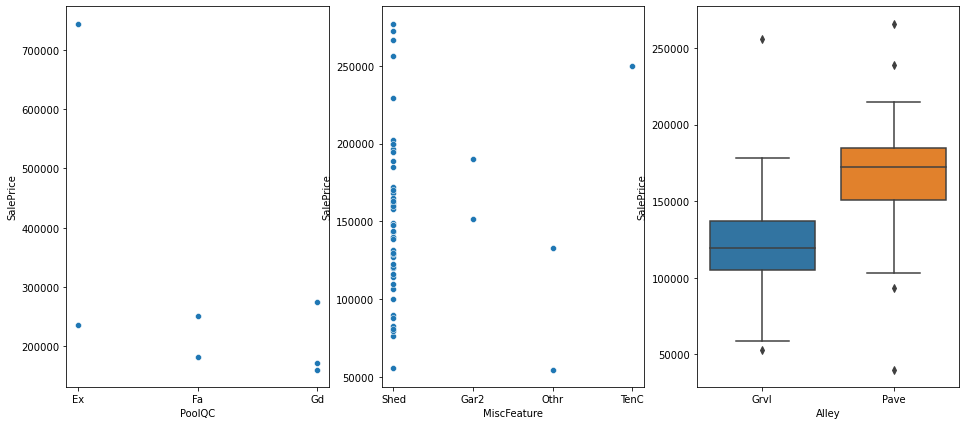

In [8]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x= df['PoolQC'], y=df['SalePrice'], ax=ax[0])
sns.scatterplot(x= df['MiscFeature'], y=df['SalePrice'], ax=ax[1])
sns.boxplot(x= df['Alley'], y=df['SalePrice'], ax=ax[2])

Maybe next time we will keep alley and see what happens. Looks like there is in increase in SalePrice with Pave over Gravel. 

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

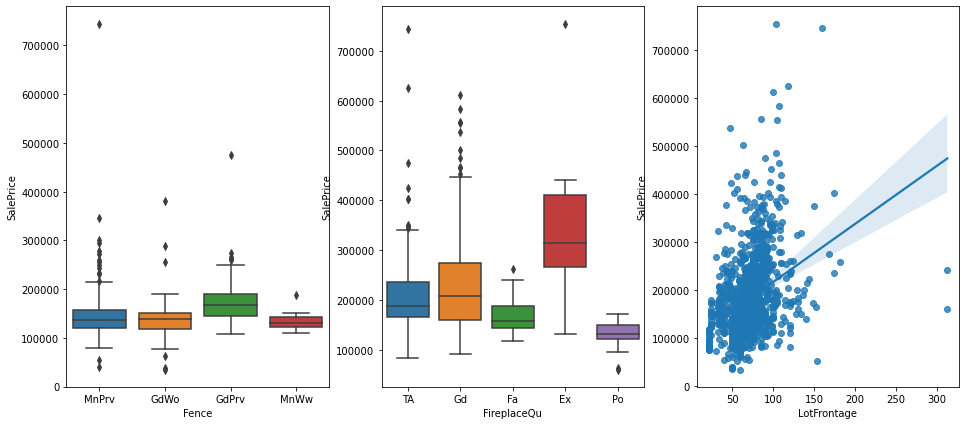

In [9]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.boxplot(x= df['Fence'], y=df['SalePrice'], ax=ax[0])
sns.boxplot(x= df['FireplaceQu'], y=df['SalePrice'], ax=ax[1])
sns.regplot(x= df['LotFrontage'], y=df['SalePrice'], ax=ax[2])

In this version we'll bin LotFrontage. If we keep it in the next version we might need to keep an eye on those outliers at high LotFrontage >300.

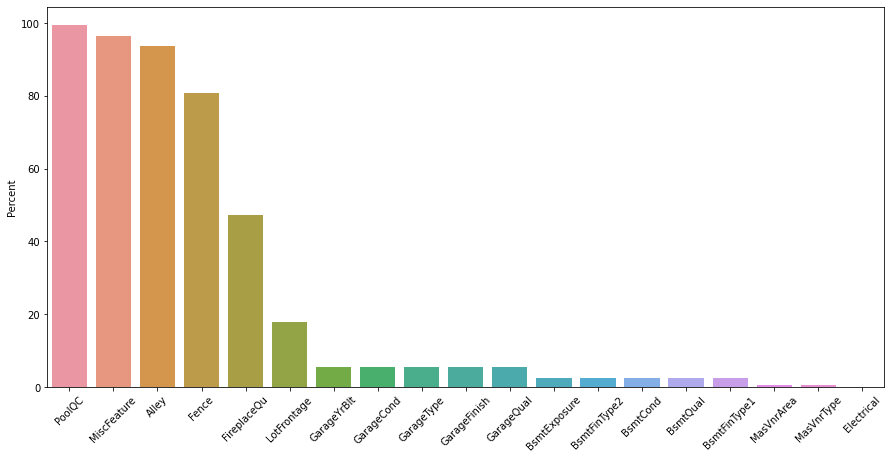

In [10]:
plt.figure(figsize = (15, 7))
sns.barplot(x= missing_vals.index, y=missing_vals['Percent'])
plt.xticks(rotation=45)
plt.show()

Let's drop anything with more than 15% of the data missing. So PoolQC (missing data likely none), MiscFeature (missing data likely none), Alley (missing data likely non), Fence (missing data likely none), Fireplace Qu (missing data likely none and LotFrontage (linear feet of street connected to property) are all dropped. 


Remove the 6 columns as noted above. Even though is isn't necessarily NaN, there is little data remaining. 

In [11]:
suspect =['PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Alley', 'LotFrontage']
df = df.drop(suspect, axis=1)
test = test.drop(suspect, axis=1)
missing_vals = missing_vals.drop(suspect, axis=0)

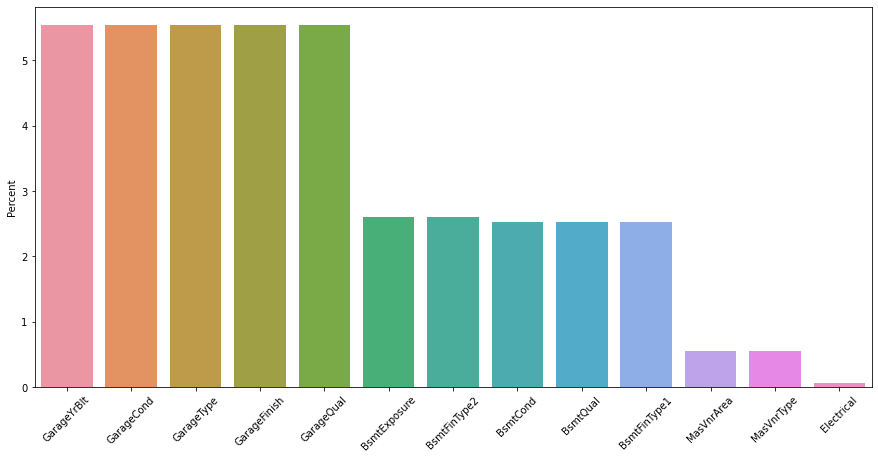

In [12]:
plt.figure(figsize = (15, 7))
sns.barplot(x= missing_vals.index, y=missing_vals['Percent'])
plt.xticks(rotation=45)
plt.show()

We will fill in the remaining missing data later

### What are our major correlations? <a name="subparagraph2"></a>
**Check pearson coorrelation matrix for highly coorelations**
* Careful person coorrelation doesn't suit catagorical independent variables. 

<AxesSubplot:>

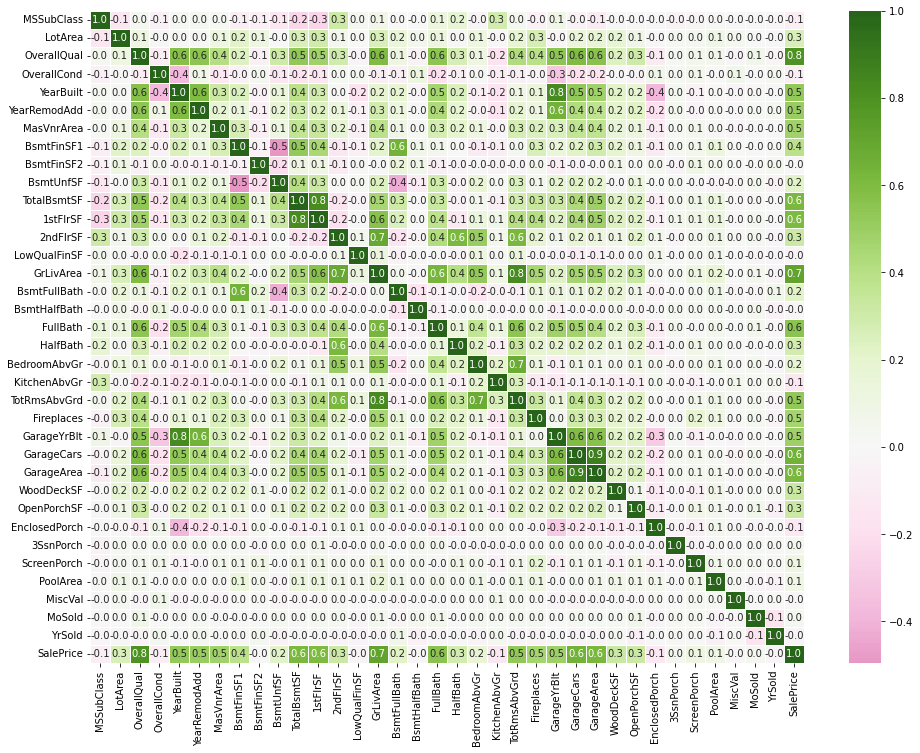

In [13]:
corr_matrix_1 = df.corr('pearson')
plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix_1, cmap="PiYG", center=0, annot=True, annot_kws={"size": 10}, fmt='.1f', linewidths=0.5)

<AxesSubplot:>

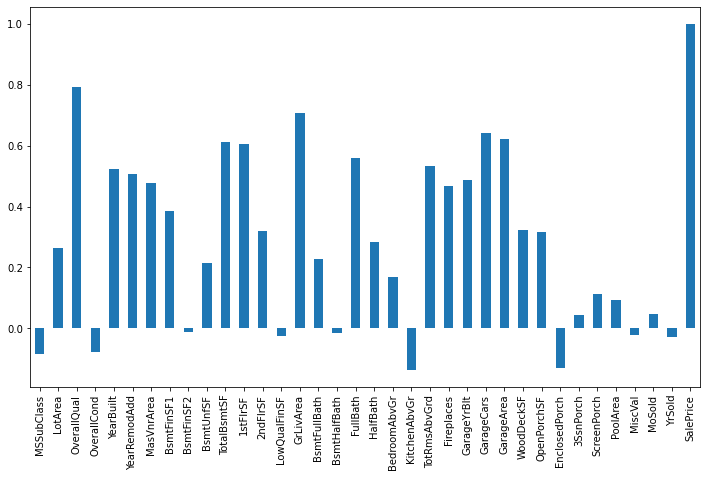

In [14]:
(corr_matrix_1['SalePrice']).plot.bar(figsize=(12,7))

In [15]:
correlations = df.corrwith(df.SalePrice)
correlations = correlations.abs().sort_values(ascending=False)
cols = list(df.corrwith(df.SalePrice)[df.corrwith(df.SalePrice).abs()>0.3].index)
cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

In [16]:
correlations

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

In [17]:
feature_coor = pd.DataFrame(correlations, columns=['before_clean'])

<AxesSubplot:>

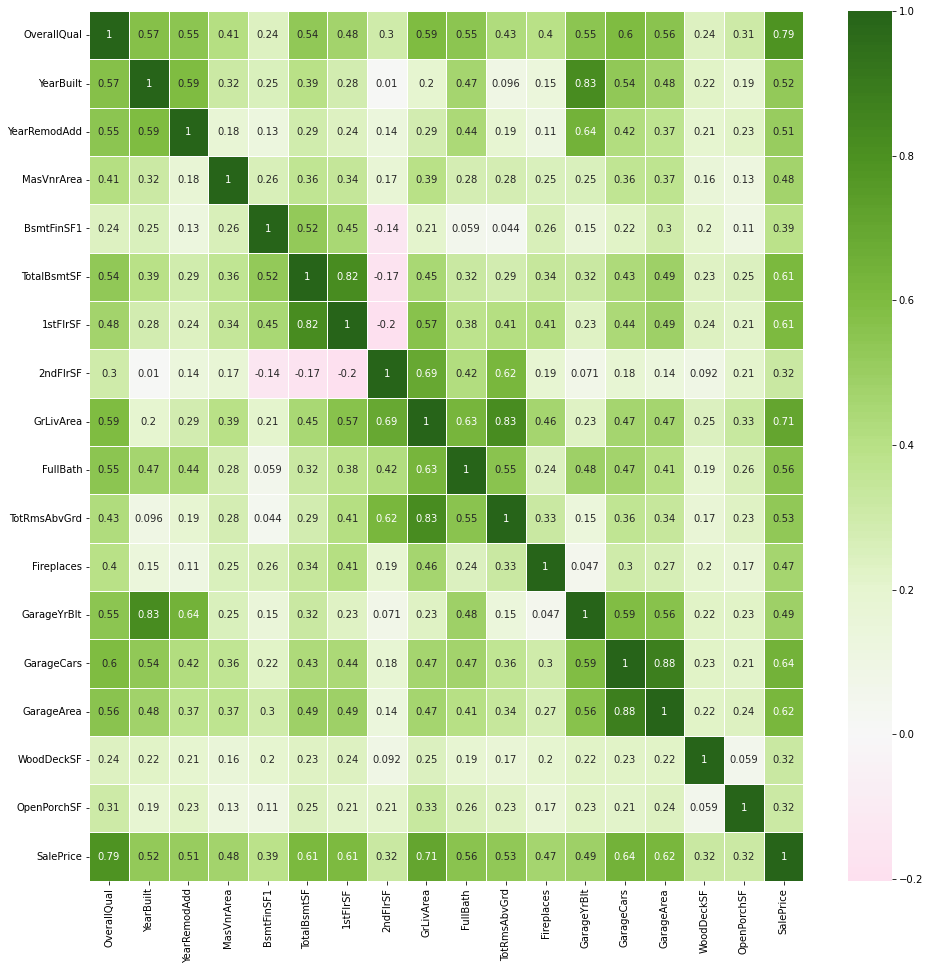

In [18]:
corr_matrix = df[cols].corr('pearson')
plt.subplots(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap="PiYG", center=0, annot=True, linewidths=0.5,)

**WRT SalePrice**
OverallQual is highest at 79% which is a catagorical variable
GrLivArea is next at 71% as a continuous variable.
GargeCars is next at 64% as a catagorical variable.
GarageArea is next at 62%.
TotalBsmtSF and 1stFlrSF are both next at 61% and are continuous
Full bath is next at 56% as a catagorical.

**Other coorelations of note for feature engineering** 
*Years:*  
YearBuilt and GarageYrBlt 83%. YearRemodAdd over 60% with both YearBuilt and GarageYrBlt.
Maybe all them all together?

*Area:* 
TotalBsmtSF and 1stFlrSF highly coorelated at 82%.
GrLivArea and TotRmsAbvGrd are highly coorelated at 83%.

*Garage:*
GarageCars and GarageArea are highly coorelated at 88%.

### Let's look closely at our target and most significant features <a name="subparagraph3"></a>
**Let's look at our dependent variable and determine if it is normally distributed**

**Are there any obvious outliers?**

**Can we exclude any features due to feature coorelation?**

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

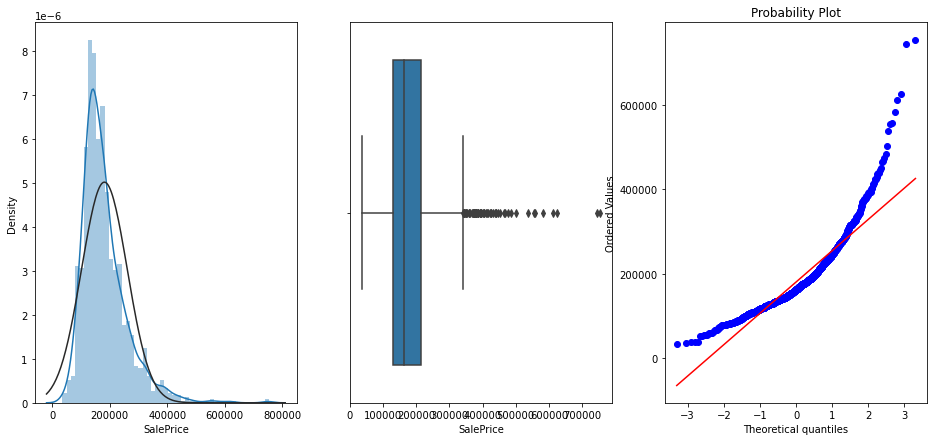

In [19]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(df['SalePrice'], fit=stats.norm, ax=ax[0])
sns.boxplot(df['SalePrice'], ax=ax[1])
stats.probplot(df['SalePrice'], plot=ax[2])

In [20]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())
shap_t,shap_p = stats.shapiro(df['SalePrice'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.882876
Kurtosis: 6.536282
Shapiro_Test: 0.869672
Shapiro_Test: 0.000000


In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). <a name="subtitle1"></a>

SalePrice isn't normally disbriuted. It is positively skewed and does't follow the diagnoal line on the probability plot. When confonting positively skewed disbrituions, log transformations, square root transformations and inverse/reciprocal transformations can be used. Box Cox runs them all dealing with positive values. Yeo-Johnson can handle negative values as well.

**Let's look at our main variables. We are looking for normal distributions, relationships with SalePrice and outliers**

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

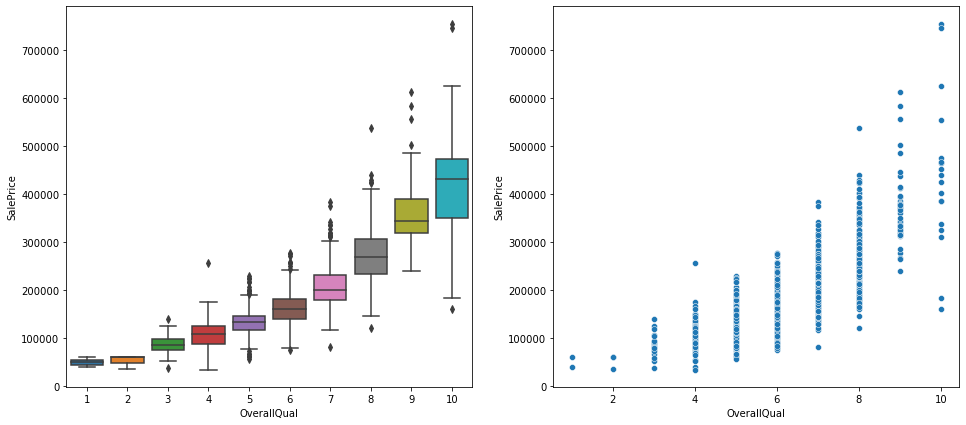

In [21]:
# catagorical variable:  OverallQual
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=df, x='OverallQual', y='SalePrice', ax=ax[0])
sns.scatterplot(data=df, x='OverallQual', y='SalePrice', ax=ax[1])

SalePrice seems to increase with OverallQual

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

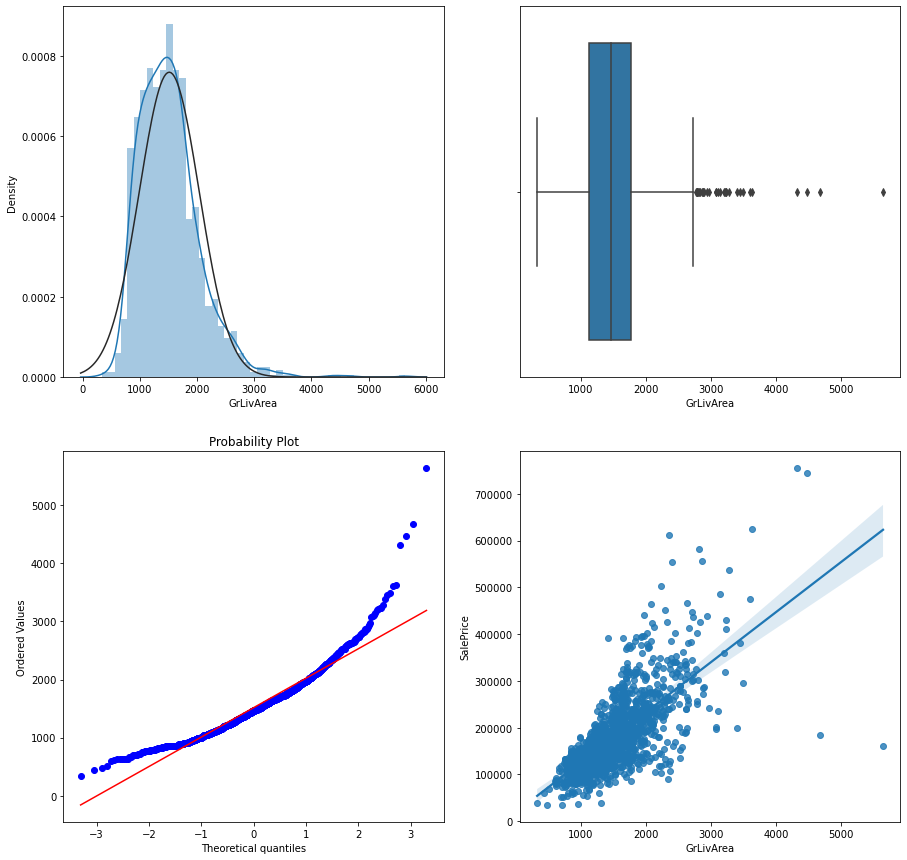

In [22]:
# continuous variable:  GrLivArea
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(df['GrLivArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(df['GrLivArea'], ax=axs[0,1])
stats.probplot(df['GrLivArea'], plot=axs[1, 0])
sns.regplot(data=df, x='GrLivArea', y='SalePrice', ax=axs[1,1])

In [23]:
print("Skewness: %f" % df['GrLivArea'].skew())
print("Kurtosis: %f" % df['GrLivArea'].kurt())
shap_t,shap_p = stats.shapiro(df['GrLivArea'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.366560
Kurtosis: 4.895121
Shapiro_Test: 0.927983
Shapiro_Test: 0.000000


SalePrice seems to increase with GrLivArea

We don't have normally disbrituted data.
In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality).

We also have some outliers. I'd suggest we drop the two values above in GrLivArea 4500


In [24]:
df = df[df['GrLivArea'] < 4500]

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

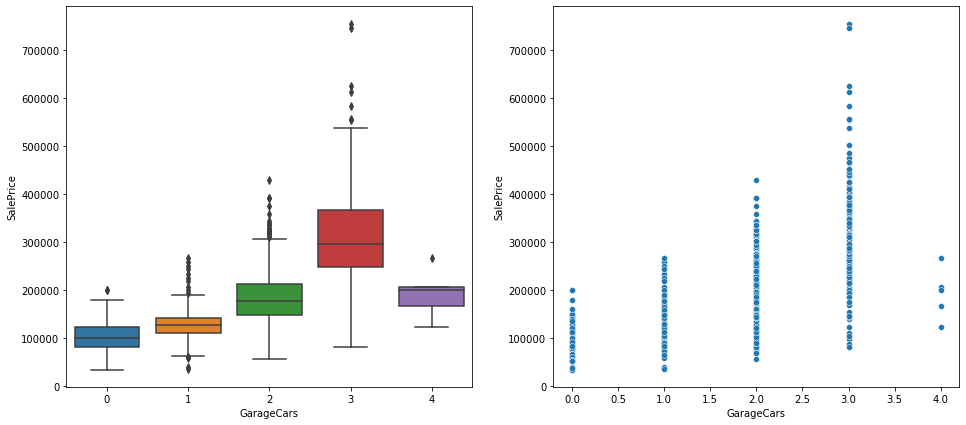

In [25]:
# catagorical variable:  GarageCars
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=df, x='GarageCars', y='SalePrice', ax=ax[0])
sns.scatterplot(data=df, x='GarageCars', y='SalePrice', ax=ax[1])

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

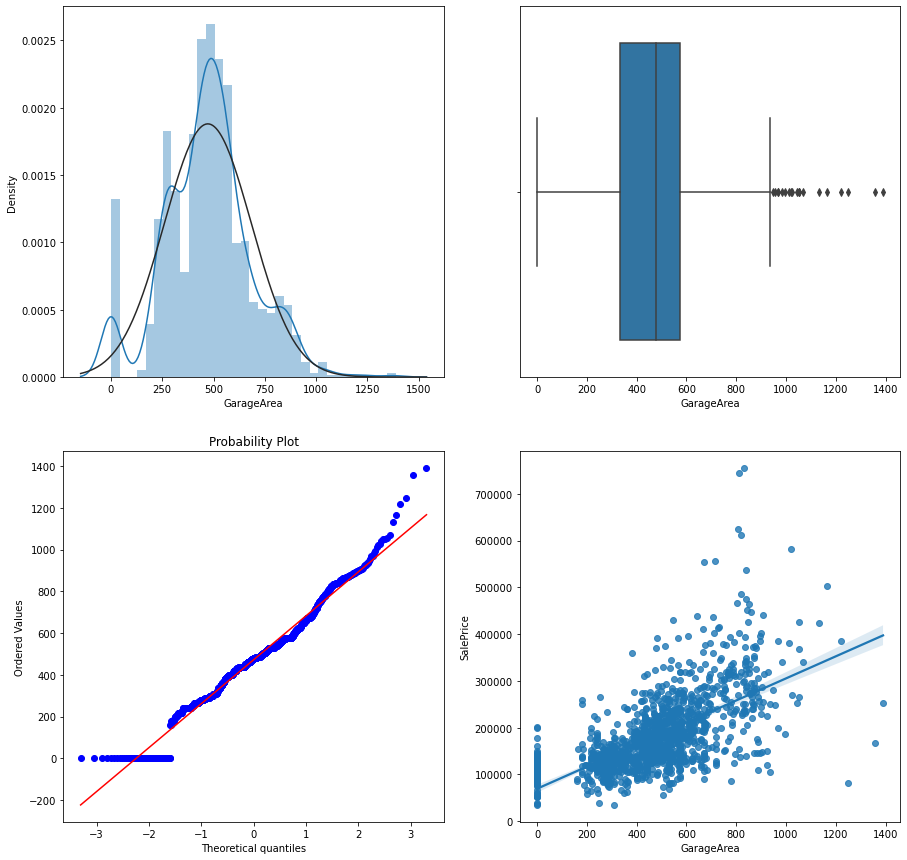

In [26]:
# continuous variable:  GarageArea
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(df['GarageArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(df['GarageArea'], ax=axs[0,1])
stats.probplot(df['GarageArea'], plot=axs[1, 0])
sns.regplot(data=df, x='GarageArea', y='SalePrice', ax=axs[1,1])

For both Garage Area and GarageCars we have a significant number of 0's. 
You do wonder when you have a large garage area and 4 for GarageCar when's going on? Maybe rural locations? I'm half tempted to get rid of GarageArea > 1230, but will leave it for now

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

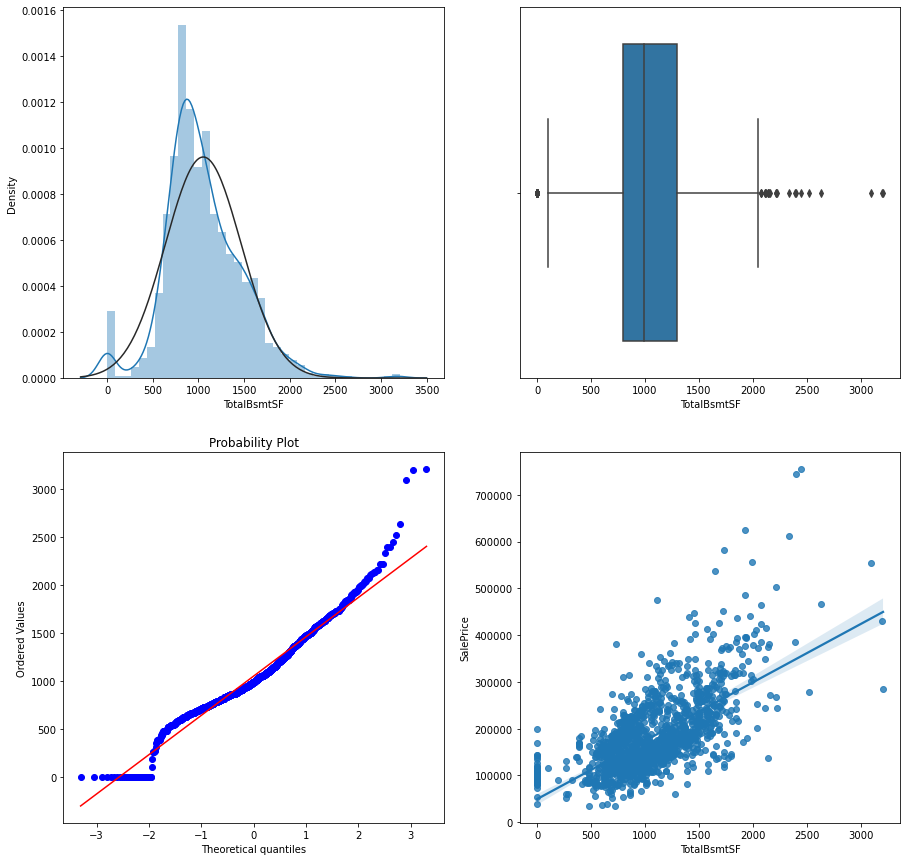

In [27]:
# continuous variable:  TotalBsmtSF
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(df['TotalBsmtSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(df['TotalBsmtSF'], ax=axs[0,1])
stats.probplot(df['TotalBsmtSF'], plot=axs[1, 0])
sns.regplot(data=df, x='TotalBsmtSF', y='SalePrice', ax=axs[1,1])

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

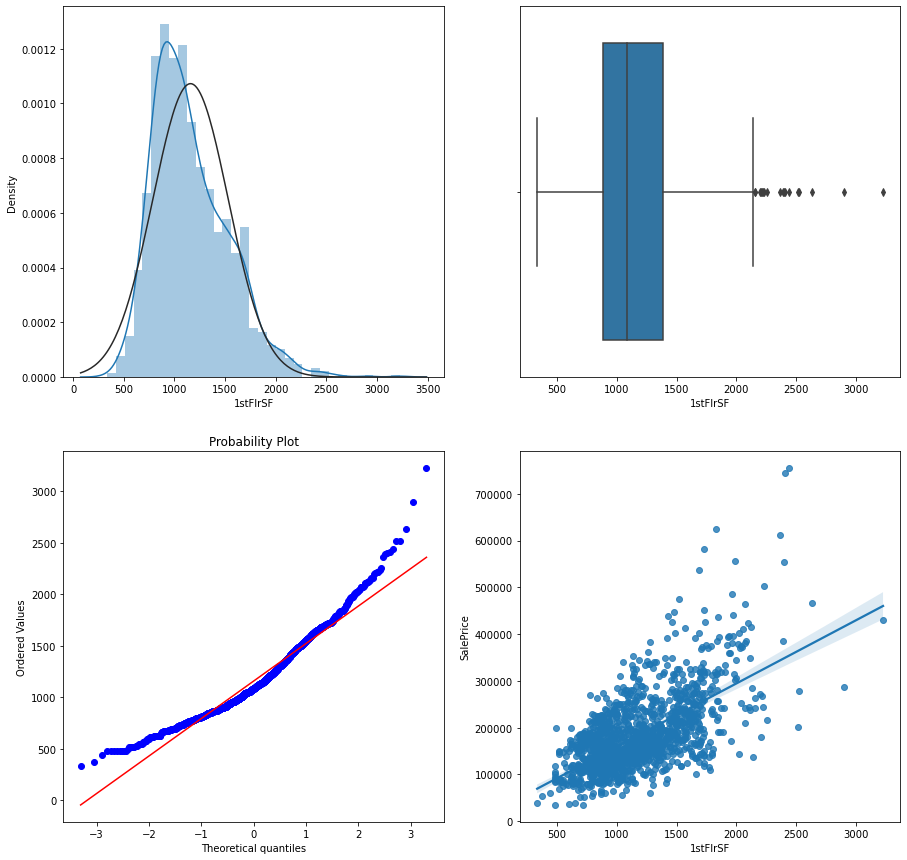

In [28]:
# continuous variable:  1stFlrSF
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(df['1stFlrSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(df['1stFlrSF'], ax=axs[0,1])
stats.probplot(df['1stFlrSF'], plot=axs[1, 0])
sns.regplot(data=df, x='1stFlrSF', y='SalePrice', ax=axs[1,1])

Again, drop the high value for 1stFlrSF and/or TotalBsmtSF. Looks better to keep 1stFlrSF over TotalBSMTSF due to the lack of 0's present. Will need to transform to normalise.
*These were removed with the drop applied to GrLiveArea

In [29]:
df = df[df['TotalBsmtSF'] < 5000]

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

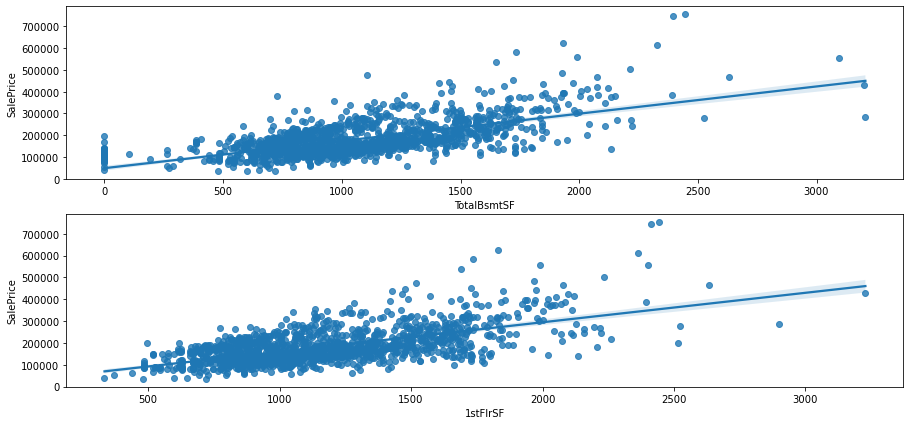

In [30]:
fig, axs = plt.subplots(2, figsize=(15, 7))
sns.regplot(data=df, x='TotalBsmtSF', y='SalePrice', ax=axs[0])
sns.regplot(data=df, x='1stFlrSF', y='SalePrice', ax=axs[1])

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

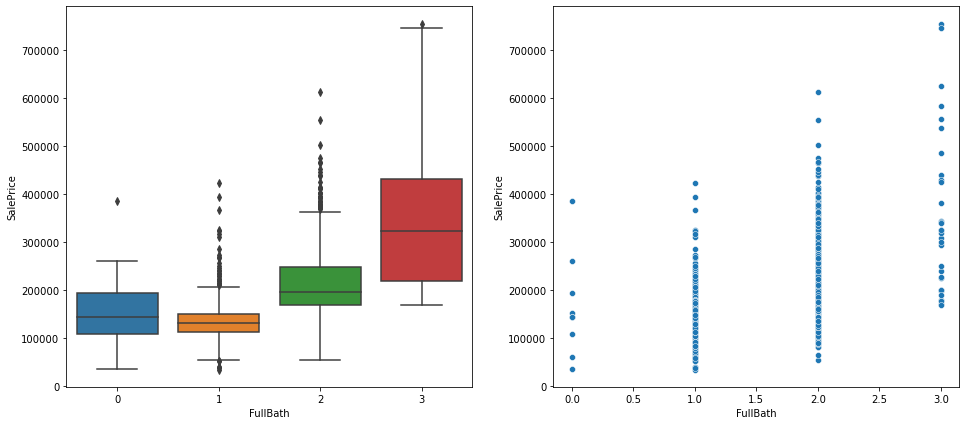

In [31]:
# catagorical variable:  FullBath
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=df, x='FullBath', y='SalePrice', ax=ax[0])
sns.scatterplot(data=df, x='FullBath', y='SalePrice', ax=ax[1])

### Let's fill in the gaps! <a name="subparagraph4"></a>
1. Get basement cols together and replace Nan with none as no basement.
2. Get garage cols together and replace Nan with none as no garage.
3. Replace NaN for garage year built and Masonry veneer area for mode. (added a load of others which were missing from the test dataframe).


In [32]:
cols_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[cols_bsmt] = df[cols_bsmt].fillna('none')
test[cols_bsmt] = test[cols_bsmt].fillna('none')

cols_Garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[cols_Garage] = df[cols_Garage].fillna('none')
test[cols_Garage] = test[cols_Garage].fillna('none')

cols_median = ['MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2']
df[cols_median] = df[cols_median].fillna(value = df[cols_median].median())
test[cols_median] = test[cols_median].fillna(value = test[cols_median].median())


This next one is a bit lazy. Just threw all the Nan from the test dataset into a method that replaces with the mode. 

In [33]:
cols_frq = ['MasVnrType', 'Electrical','MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'SaleType']
df[cols_frq] = df[cols_frq].apply(lambda x: x.fillna(x.value_counts().index[0]))
test[cols_frq] = test[cols_frq].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [34]:
df['GarageArea'] = df['GarageArea'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)

In [35]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].min())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].min())

In [36]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals>0]
missing_vals


Series([], dtype: int64)

In [37]:
missing_vals_test = test.isnull().sum()
missing_vals_test = missing_vals_test[missing_vals_test>0]
missing_vals_test


Series([], dtype: int64)

Yay! No more NaN! Let's double check the coorelation table before we start our feature engineering

<AxesSubplot:>

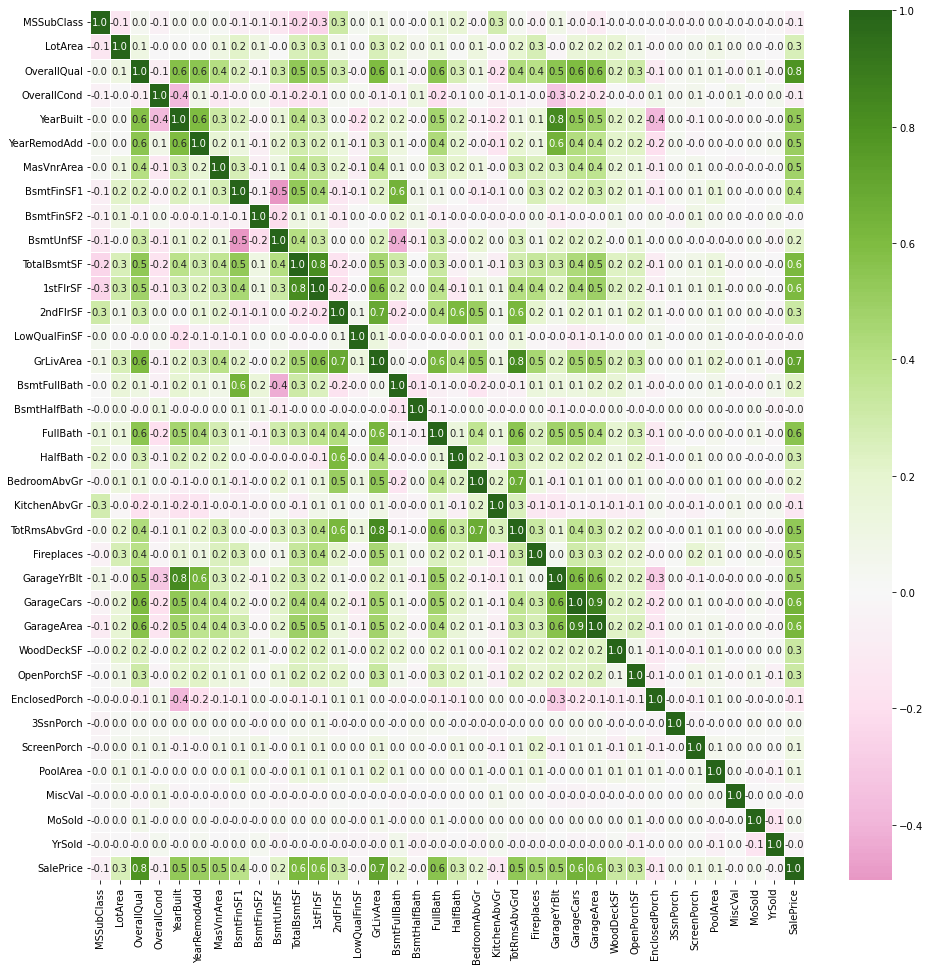

In [38]:
corr_matrix_2 = df.corr('pearson')
plt.subplots(figsize=(16, 16))
sns.heatmap(corr_matrix_1, cmap="PiYG", center=0, annot=True, annot_kws={"size": 10}, fmt='.1f', linewidths=0.5)

* ## Let's Transform those features! <a name="paragraph2"></a>
* If needed skewed transform features
* If loads of 0's create a catagorical variable then tansform non-zero if needed

[Recall SalePrice was not normally distributed](#subtitle1)

### Log Transform SalePrice! <a name="subparagraph5"></a>

In [39]:
#  Apply the log transform
df['SalePrice_log'] = np.log(df['SalePrice'])

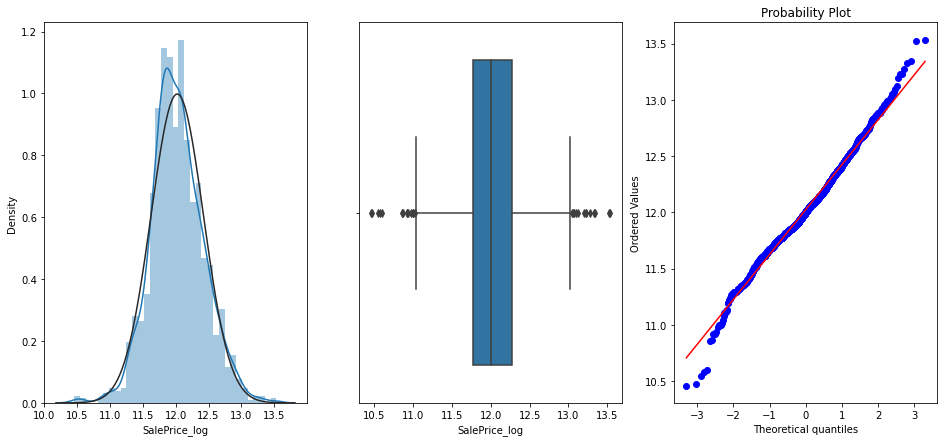

In [40]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(df['SalePrice_log'], fit=stats.norm, ax=ax[0])
sns.boxplot(df['SalePrice_log'], ax=ax[1])
res = stats.probplot(df['SalePrice_log'], plot=ax[2])

In [41]:
print("Skewness: %f" % df['SalePrice_log'].skew())
print("Kurtosis: %f" % df['SalePrice_log'].kurt())
shap_t,shap_p = stats.shapiro(df['SalePrice_log'])
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 0.121568
Kurtosis: 0.804764
Shapiro_Test: 0.991239
Shapiro_Test: 0.000000


In [42]:
df['SalePrice'] = df['SalePrice_log']
df = df.drop(['SalePrice_log'], axis=1)

That's some normal data!

### Feature Engineering! <a name="subparagraph6"></a>

Let's start with these three and see how they relate to SP
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
* GarageYrBlt: Year garage was built

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

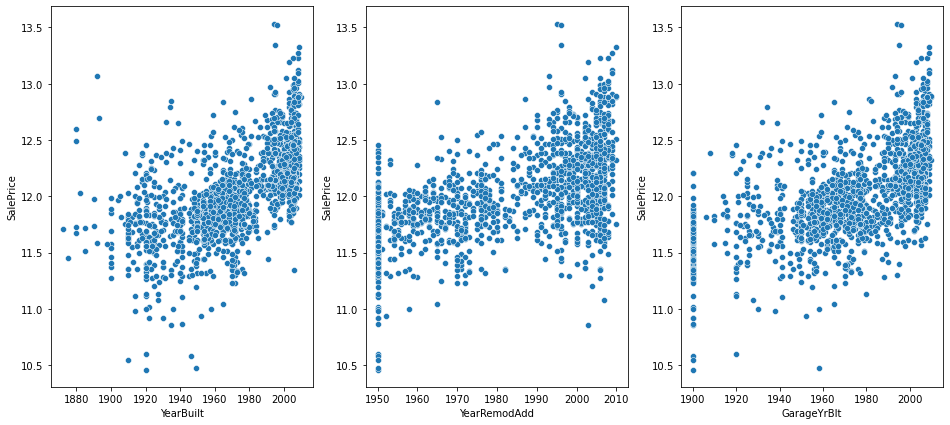

In [43]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x=df['YearBuilt'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['YearRemodAdd'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['GarageYrBlt'], y= df['SalePrice'], ax=ax[2])

In [44]:
df['TotalYears'] = df['YearBuilt'] + (df['YearRemodAdd']-1950) + (df['GarageYrBlt']-df['GarageYrBlt'].min())
test['TotalYears'] = test['YearBuilt'] + (test['YearRemodAdd']-1950) + (test['GarageYrBlt']-test['GarageYrBlt'].min())

<AxesSubplot:xlabel='TotalYears', ylabel='SalePrice'>

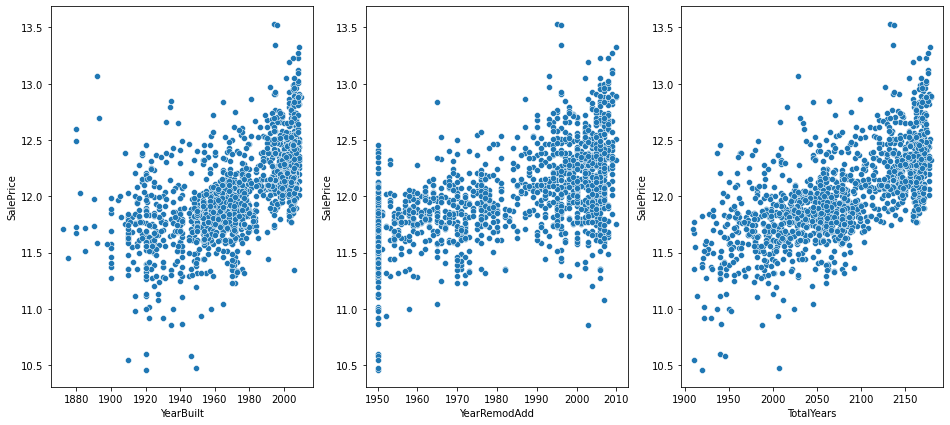

In [45]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x=df['YearBuilt'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['YearRemodAdd'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['TotalYears'], y= df['SalePrice'], ax=ax[2])

In [46]:
df = df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)
test = test.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)

Let's start with the next four and see how they relate to SP
* GrLivArea: Above grade (ground) living area square feet
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* TotalBsmtSF: Total square feet of basement area

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

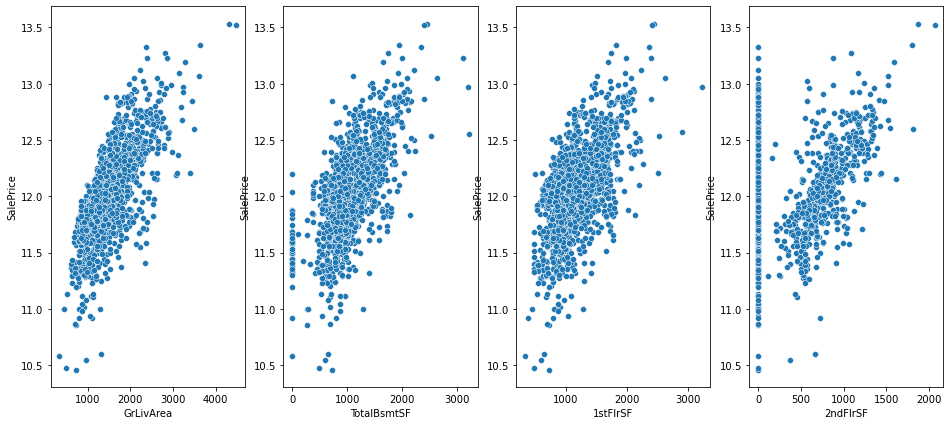

In [47]:
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.scatterplot(x=df['GrLivArea'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['TotalBsmtSF'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['1stFlrSF'], y= df['SalePrice'], ax=ax[2])
sns.scatterplot(x=df['2ndFlrSF'], y= df['SalePrice'], ax=ax[3])

In [48]:
df['OverallSF'] = df['GrLivArea']+df['TotalBsmtSF']
df['TopFlrSF'] = df['1stFlrSF']+df['2ndFlrSF']
test['OverallSF'] = test['GrLivArea']+test['TotalBsmtSF']
test['TopFlrSF'] = test['1stFlrSF']+test['2ndFlrSF']

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

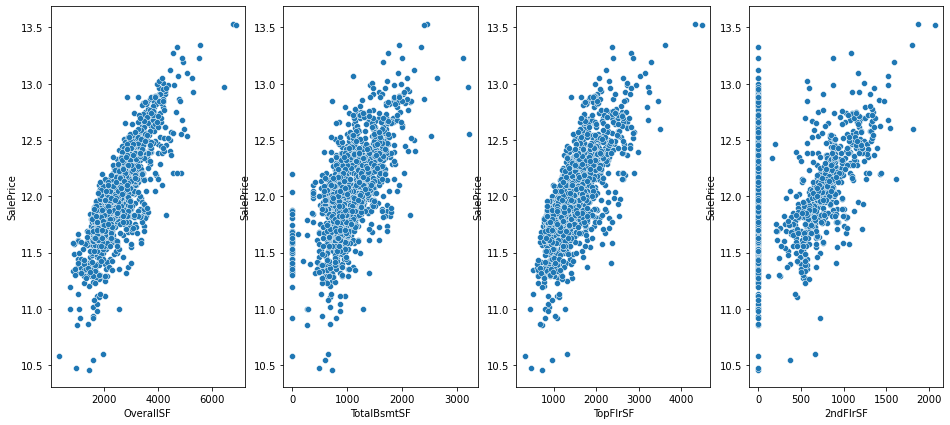

In [49]:
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.scatterplot(x=df['OverallSF'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['TotalBsmtSF'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['TopFlrSF'], y= df['SalePrice'], ax=ax[2])
sns.scatterplot(x=df['2ndFlrSF'], y= df['SalePrice'], ax=ax[3])

In [50]:
df = df.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)
test = test.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)

Let's start with the next four and see how they relate to SP
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice'>

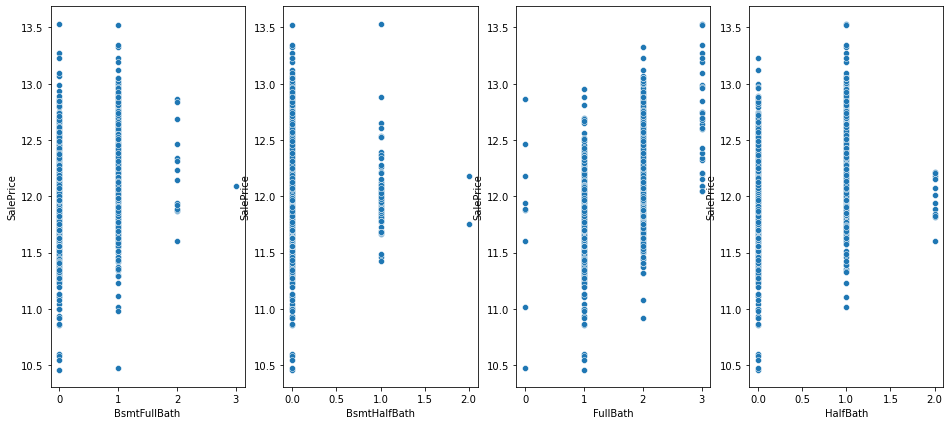

In [51]:
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.scatterplot(x=df['BsmtFullBath'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['BsmtHalfBath'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['FullBath'], y= df['SalePrice'], ax=ax[2])
sns.scatterplot(x=df['HalfBath'], y= df['SalePrice'], ax=ax[3])

<AxesSubplot:xlabel='TotalBath', ylabel='SalePrice'>

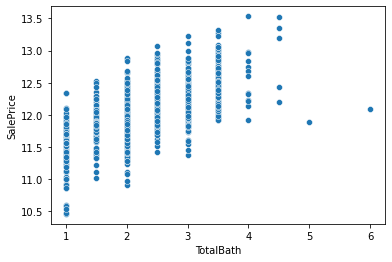

In [52]:
df['TotalBath'] = df['FullBath']+df['BsmtFullBath']+(df['HalfBath']/2)+(df['BsmtHalfBath']/2)
test['TotalBath'] = test['FullBath']+test['BsmtFullBath']+(test['HalfBath']/2)+(test['BsmtHalfBath']/2)
sns.scatterplot(x=df['TotalBath'], y= df['SalePrice'])

In [53]:
df = df.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)
test = test.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)

Let's start with the next give and see how they relate to SP

* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet


<AxesSubplot:xlabel='ScreenPorch', ylabel='SalePrice'>

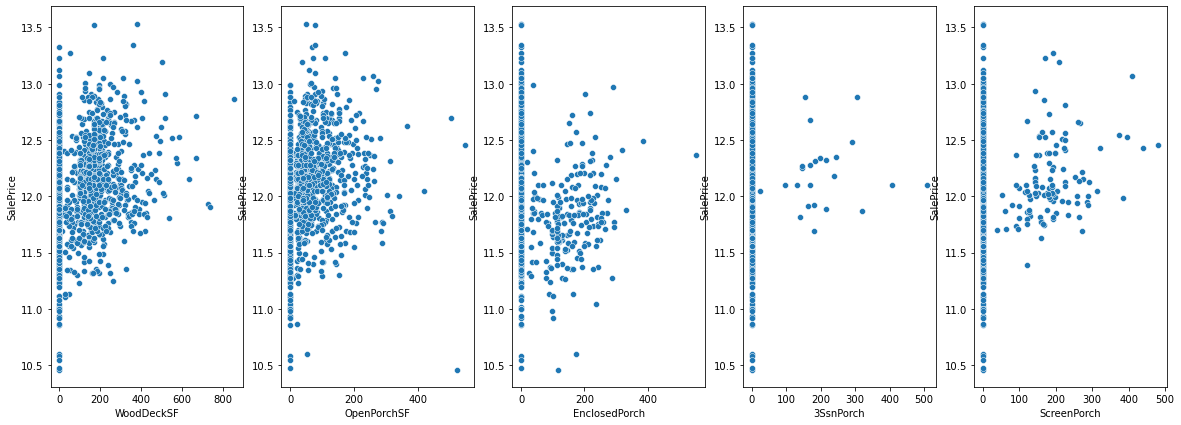

In [54]:
fig, ax = plt.subplots(1,5, figsize =(20, 7))
sns.scatterplot(x=df['WoodDeckSF'], y= df['SalePrice'], ax=ax[0])
sns.scatterplot(x=df['OpenPorchSF'], y= df['SalePrice'], ax=ax[1])
sns.scatterplot(x=df['EnclosedPorch'], y= df['SalePrice'], ax=ax[2])
sns.scatterplot(x=df['3SsnPorch'], y= df['SalePrice'], ax=ax[3])
sns.scatterplot(x=df['ScreenPorch'], y= df['SalePrice'], ax=ax[4])

In [55]:
df['OpenPorchSF'].nlargest(3)

1328    547
495     523
583     502
Name: OpenPorchSF, dtype: int64

In [56]:
df = df.drop(index=495)
df['OpenPorchSF'].nlargest(3)

1328    547
583     502
854     418
Name: OpenPorchSF, dtype: int64

<AxesSubplot:xlabel='TotalDeckPorch', ylabel='SalePrice'>

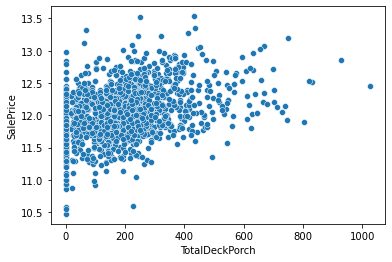

In [57]:
df['TotalDeckPorch'] = df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch']
test['TotalDeckPorch'] = test['WoodDeckSF']+test['OpenPorchSF']+test['EnclosedPorch']+test['3SsnPorch']+test['ScreenPorch']
sns.scatterplot(x=df['TotalDeckPorch'], y= df['SalePrice'])                                                                                               

In [58]:
df = df.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)
test = test.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)  

Converting non-numeric predictors stored as numbers into string

In [59]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)
df['TotalBath'] = df['TotalBath'].apply(str)
df['KitchenAbvGr'] = df['KitchenAbvGr'].apply(str)
df['OverallCond'] = df['OverallCond'].apply(str)
df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(str)
df['Fireplaces'] = df['Fireplaces'].apply(str)
df['OverallQual'] = df['OverallQual'].apply(str)
df['BedroomAbvGr'] = df['BedroomAbvGr'].apply(str)
df['GarageCars'] = df['GarageCars'].apply(str)

test['MSSubClass'] = test['MSSubClass'].apply(str)
test['YrSold'] = test['YrSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
test['TotalBath'] = test['TotalBath'].apply(str)
test['KitchenAbvGr'] = test['KitchenAbvGr'].apply(str)
test['OverallCond'] = test['OverallCond'].apply(str)
test['TotRmsAbvGrd'] = test['TotRmsAbvGrd'].apply(str)
test['Fireplaces'] = test['Fireplaces'].apply(str)
test['OverallQual'] = test['OverallQual'].apply(str)
test['BedroomAbvGr'] = test['BedroomAbvGr'].apply(str)
test['GarageCars'] = test['GarageCars'].apply(str)


### Let's evaluate how we did! <a name="subparagraph7"></a>

<AxesSubplot:>

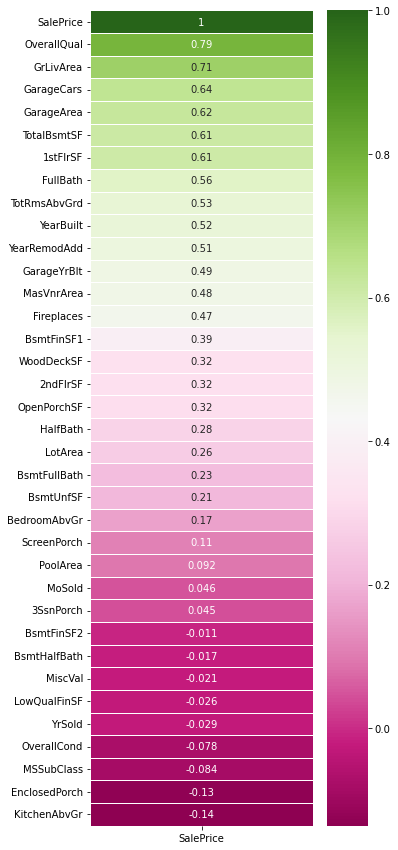

In [60]:
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_1[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

<AxesSubplot:>

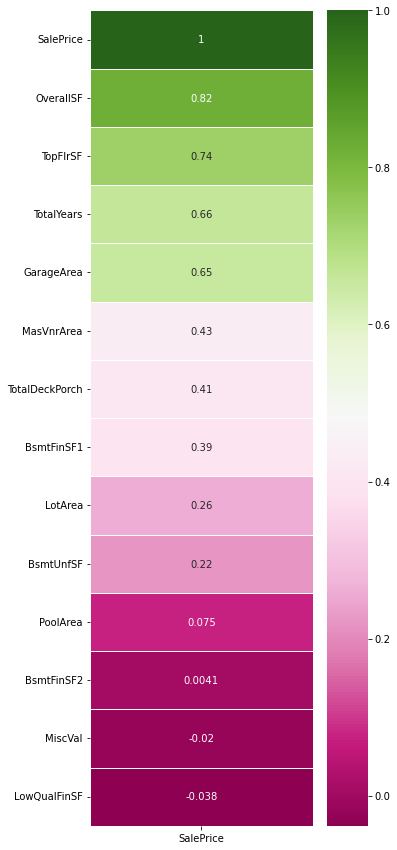

In [61]:
corr_matrix_3 = df.corr('pearson')
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_3[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

Some features have dropped off due to feature engineering or being properly labeled as catagorical features. 
However those that are remaining are showing improved coorelations. 

### Let's check skewness, see if we need more feature engineering and then transform for normal distributions! <a name="subparagraph8"></a>
Let's define which numerical features are not normally distributed 

In [62]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'GarageArea', 'PoolArea', 'MiscVal', 'SalePrice',
       'TotalYears', 'OverallSF', 'TopFlrSF', 'TotalDeckPorch'],
      dtype='object')


In [63]:
skewed_features = df[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'BsmtFinSF2',
       'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'BsmtUnfSF', 'OverallSF',
       'BsmtFinSF1'],
      dtype='object')

Let's look at the first 5 against SalePrice

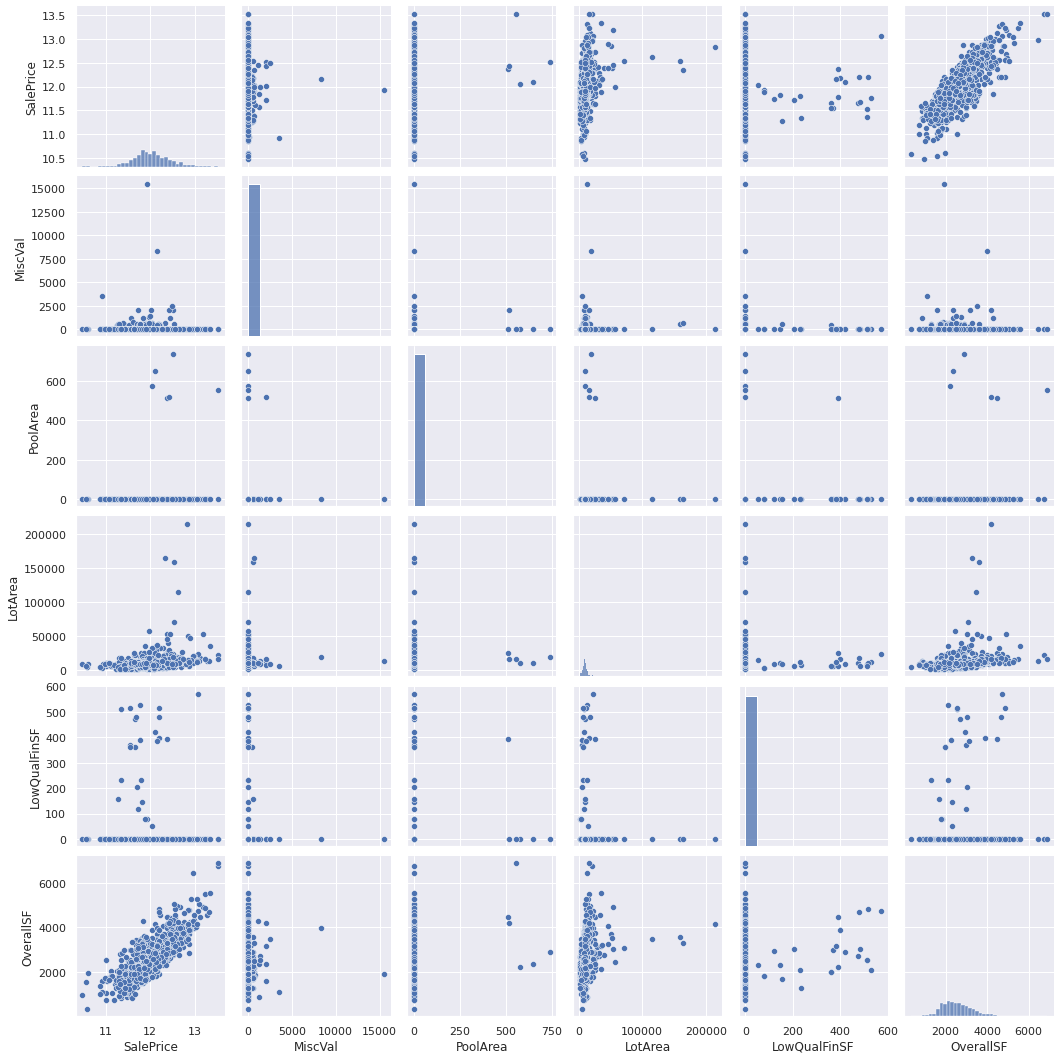

In [64]:
#scatterplot
cols_pair_1 = ['SalePrice', 'MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'OverallSF']
sns.set()
sns.pairplot(df[cols_pair_1], size = 2.5)
plt.show();

* Since we remove MiscFeature, I'd suggest we remove MiscVal. No significant correlation anyways and loads of 0's
* Let's convert PoolArea into a categorical feature PoolPresent 0 if 0 and 1 if present
* Let's convert LowQualFinSF into a categorical feature LowQualFinPresent 0 if 0 and 1 if present

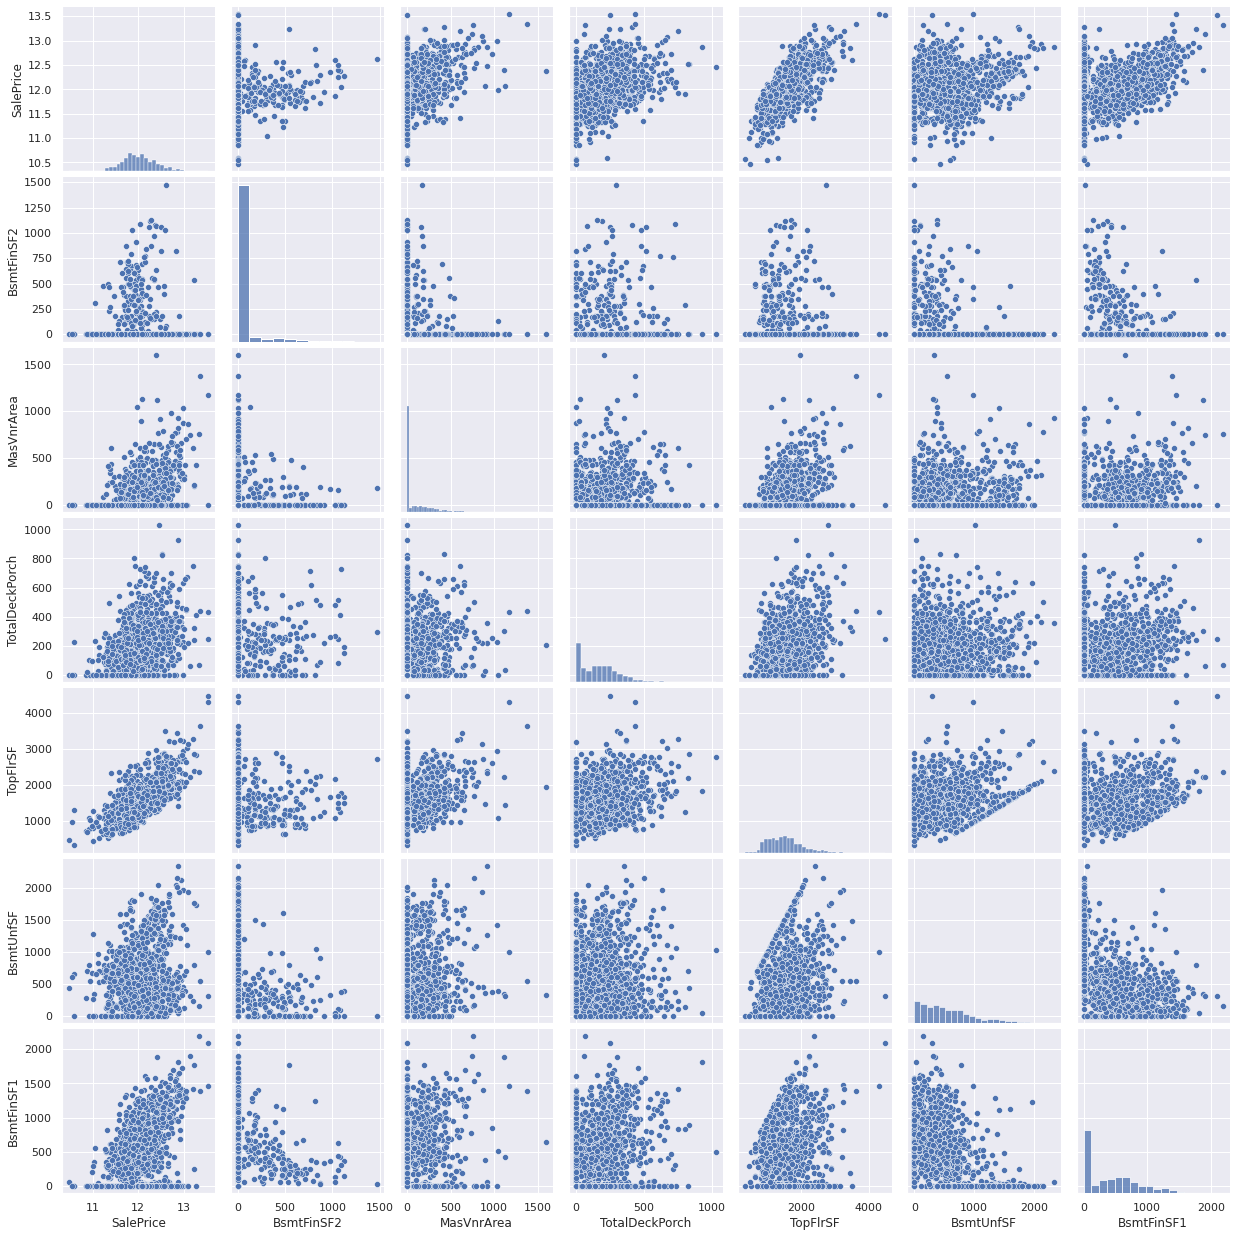

In [65]:
#scatterplot
cols_pair_2 = ['SalePrice', 'BsmtFinSF2', 'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'BsmtUnfSF', 'BsmtFinSF1']
sns.set()
sns.pairplot(df[cols_pair_2], size = 2.5)
plt.show();

Not totally happy with BsmtFinSF2 but will leave for now

In [66]:
df['PoolPresent'] = 0 
df.loc[df['PoolArea']>0,'PoolPresent'] = 1

test['PoolPresent'] = 0 
test.loc[test['PoolArea']>0,'PoolPresent'] = 1
    
df['LowQualFinPresent'] = 0 
df.loc[df['LowQualFinSF']>0,'LowQualFinPresent'] = 1

test['LowQualFinPresent'] = 0 
test.loc[test['LowQualFinSF']>0,'LowQualFinPresent'] = 1
    
df = df.drop(['MiscVal', 'PoolArea', 'LowQualFinSF'], axis=1)
test = test.drop(['MiscVal','PoolArea', 'LowQualFinSF'], axis=1)

In [67]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'GarageArea', 'SalePrice', 'TotalYears', 'OverallSF', 'TopFlrSF',
       'TotalDeckPorch', 'PoolPresent', 'LowQualFinPresent'],
      dtype='object')


In [68]:
skewed_features = df[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['PoolPresent', 'LotArea', 'LowQualFinPresent', 'BsmtFinSF2',
       'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'BsmtUnfSF', 'OverallSF',
       'BsmtFinSF1'],
      dtype='object')

In [69]:
for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

I'm not applying the transformation to the test dataframe until the end.

### OneHotEncoding catagorical features! <a name="subparagraph9"></a>
I orginally did pandas get dummies however applying that to the test data was a problem for the model. Essentially I didn't maintain the same number of columns/features. So we'll go with OneHotEncoding!


In [70]:
categorical_features = df.select_dtypes(include = ["object"]).columns
print(categorical_features)

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'TotalBath'],
      dtype='object')


In [71]:
print(df.shape)
print(test.shape)

(1457, 62)
(1459, 62)


In [72]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals>0]
missing_vals

Series([], dtype: int64)

In [73]:
# Reset the index after dropping some outliers
df = df.reset_index(drop=True)
test = test.reset_index(drop=True)

In [74]:
# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, )
# Apply ohe on data
ohe.fit(df[categorical_features])
cat_ohe = ohe.transform(df[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_features))


In [75]:
df = df.drop(categorical_features, axis=1)

In [76]:
#concat with original data and drop original columns
df = pd.concat([df, ohe_df], axis=1)

In [77]:
print(df.shape)
print(test.shape)

(1457, 349)
(1459, 62)


In [78]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals>0]
missing_vals

Series([], dtype: int64)

In [79]:
correlations_final = df.corrwith(df.SalePrice)
correlations_final = correlations_final.abs().sort_values(ascending=False)
cols_final = list(df.corrwith(df.SalePrice)[df.corrwith(df.SalePrice).abs()>0.4].index)

### Let's do one final coorelation evaluation! <a name="subparagraph10"></a>

<AxesSubplot:>

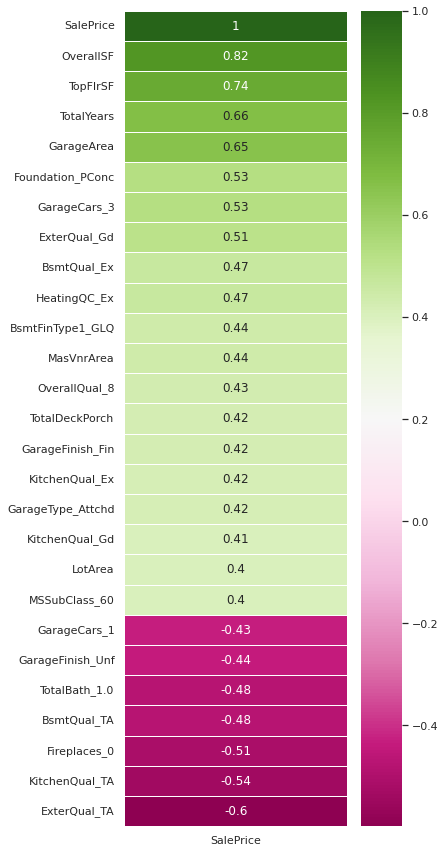

In [80]:
corr_matrix_4 = df[cols_final].corr('pearson')
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_4[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

Some of the encoded catagorical features are showing high pearson coorelations!!! Some high impact on the negative side too. 

In [81]:
print(df.shape)
print(test.shape)

(1457, 349)
(1459, 62)


* ## Let's build some models! <a name="paragraph3"></a>
* Split the data

In [82]:
# Import the libraries needed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

In [83]:
y = df['SalePrice']

In [84]:
df = df.drop(['SalePrice'], axis=1)

In [85]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 348)
X_test : (438, 348)
y_train : (1019,)
y_test : (438,)


In [86]:
numerical_features_x = [x for i,x in enumerate(numerical_features) if(x!='SalePrice') and (x!='LowQualFinPresent') and (x!='PoolPresent')]
numerical_features_x

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'GarageArea',
 'TotalYears',
 'OverallSF',
 'TopFlrSF',
 'TotalDeckPorch']

In [87]:
stdSc_x= StandardScaler()
stdSc_y= StandardScaler()

X_train[numerical_features_x]  = stdSc_x.fit_transform(X_train[numerical_features_x])
X_test[numerical_features_x]  = stdSc_x.transform(X_test[numerical_features_x])

In [88]:
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 348)
X_test : (438, 348)
y_train : (1019,)
y_test : (438,)


In [89]:
# Create rsme metric
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [90]:
# 10 fold cross validatoin
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [91]:
# Let's use these models 
baseline_models = ['Ridge_Reg.','Lasso_Reg.', 'ElasticNet', 'XGB_Reg.']

In [92]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

### Ridge Regression! <a name="subparagraph11"></a>

In [93]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline

alphas = [8.5, 9, 9.5]
     
ridgecv_reg= RidgeCV(alphas=alphas, cv=kf)
ridgecv_reg.fit(X_train, y_train)
y_test_rdg = ridgecv_reg.predict(X_test)
y_train_rdg = ridgecv_reg.predict(X_train)
alpha = ridgecv_reg.alpha_
print("Best alpha :", alpha)
print("Now try again for more precision on alpha, with alpha centered around " + str(alpha))
print("Ridge RMSE on Training set :", rmse_cv_train(ridgecv_reg).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridgecv_reg).mean())
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_rdg))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_rdg))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_rdg))

Best alpha : 8.5
Now try again for more precision on alpha, with alpha centered around 8.5
Ridge RMSE on Training set : 0.11445210107307835
Ridge RMSE on Test set : 0.12532302508662943
----------RidgeCV----------
R square Accuracy:  0.9249645813221836
Mean Absolute Error Accuracy:  0.0753011751010676
Mean Squared Error Accuracy:  0.01182225318456343


Text(0, 0.5, 'Real values')

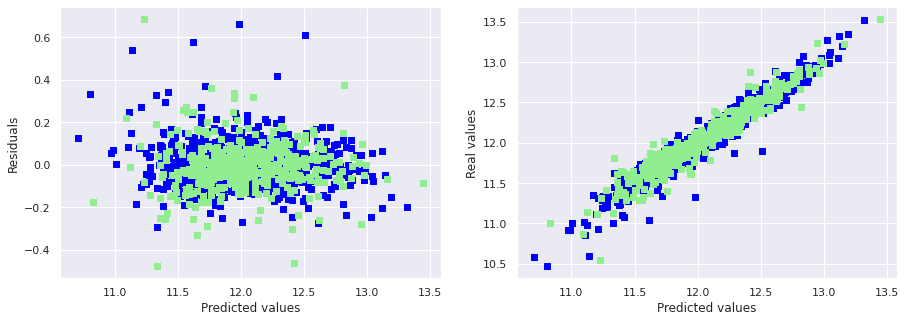

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

RidgeCV picked 343 features and eliminated the other 5 features


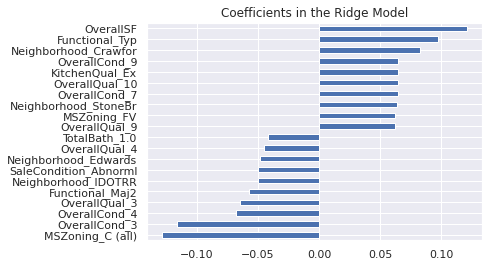

In [95]:
coefs_rdg = pd.Series(ridgecv_reg.coef_, index = X_train.columns)
print("RidgeCV picked " + str(sum(coefs_rdg != 0)) + " features and eliminated the other " +  str(sum(coefs_rdg == 0)) + " features")
imp_coefs_rdg = pd.concat([coefs_rdg.sort_values().head(10), coefs_rdg.sort_values().tail(10)])
imp_coefs_rdg.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### Lasso regularizations! <a name="subparagraph12"></a>

In [96]:
from sklearn.linear_model import LassoCV

alphas = [0.0004, 0.0005, 0.0006]

lassocv_reg= LassoCV(alphas=alphas, cv=kf)
lassocv_reg.fit(X_train, y_train)
y_test_lasso=lassocv_reg.predict(X_test)
y_train_lasso = lassocv_reg.predict(X_train)
alpha = lassocv_reg.alpha_
print("Best alpha :", alpha)
print("Now try again for more precision on alpha, with alpha centered around" + str(alpha))
print("Ridge RMSE on Training set :", rmse_cv_train(lassocv_reg).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(lassocv_reg).mean())
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_lasso))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_lasso))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_lasso))

Best alpha : 0.0005
Now try again for more precision on alpha, with alpha centered around0.0005
Ridge RMSE on Training set : 0.1132180638717406
Ridge RMSE on Test set : 0.12899130261624836
----------LassoCV----------
R square Accuracy:  0.9265937308010902
Mean Absolute Error Accuracy:  0.07485705384014019
Mean Squared Error Accuracy:  0.011565571500706483


Text(0, 0.5, 'Real values')

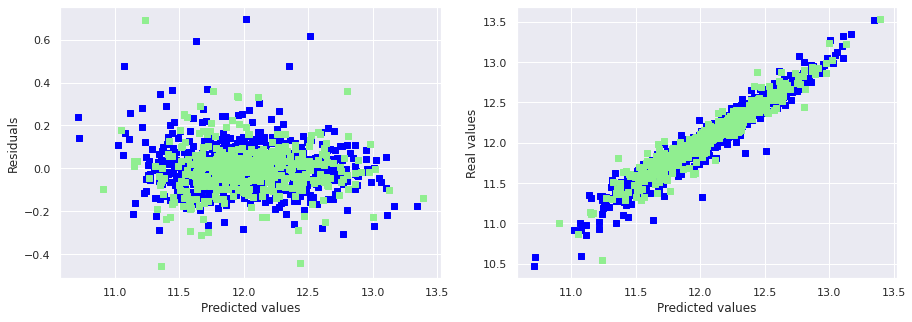

In [97]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_lasso, y_train_lasso - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_lasso, y_test_lasso - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_lasso, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_lasso, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

LassoCV picked 133 features and eliminated the other 215 features


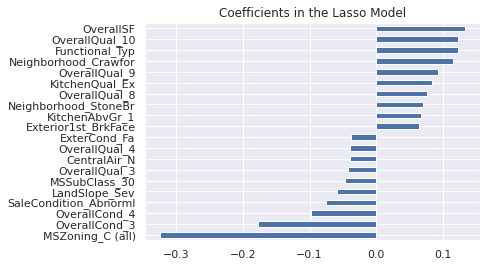

In [98]:
coefs_lasso = pd.Series(lassocv_reg.coef_, index = X_train.columns)
print("LassoCV picked " + str(sum(coefs_lasso != 0)) + " features and eliminated the other " +  str(sum(coefs_lasso == 0)) + " features")
imp_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])
imp_coefs_lasso.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

### Elastic Net regularization! <a name="subparagraph13"></a>

In [99]:
from sklearn.linear_model import ElasticNetCV

alphas=[0.0004, 0.0005, 0.0006] 
l1ratio=[0.8, 0.9, 1]

elasticv_reg= ElasticNetCV(alphas=alphas, l1_ratio=l1ratio, cv=kf)
elasticv_reg.fit(X_train, y_train)
y_test_elastic=elasticv_reg.predict(X_test)
y_train_elastic = elasticv_reg.predict(X_train)
alpha = elasticv_reg.alpha_
ratio = elasticv_reg.l1_ratio_
print("Best alpha :", alpha)
print("Best l1ratio :", ratio)
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
print("Elastic RMSE on Training set :", rmse_cv_train(elasticv_reg).mean())
print("Elastic RMSE on Test set :", rmse_cv_test(elasticv_reg).mean())
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_elastic))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_elastic))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_elastic))

Best alpha : 0.0005
Best l1ratio : 1.0
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.0005
Elastic RMSE on Training set : 0.11333692307935954
Elastic RMSE on Test set : 0.12920731485915707
----------ElasticNetCV----------
R square Accuracy:  0.9265937308010902
Mean Absolute Error Accuracy:  0.07485705384014019
Mean Squared Error Accuracy:  0.011565571500706483


Text(0, 0.5, 'Real values')

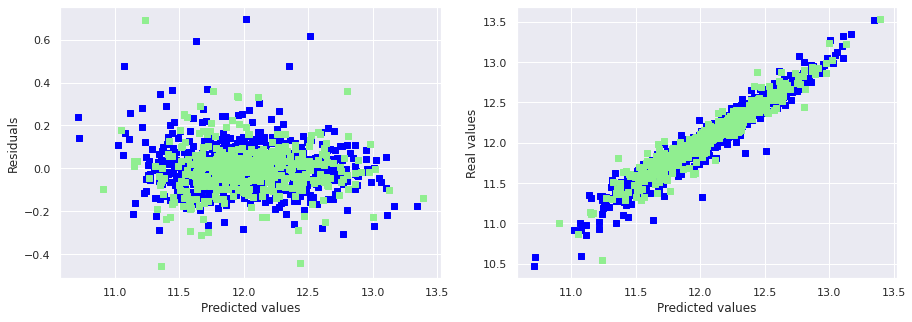

In [100]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_elastic, y_train_elastic - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_elastic, y_test_elastic - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_elastic, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_elastic, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

ElasticCV picked 133 features and eliminated the other 215 features


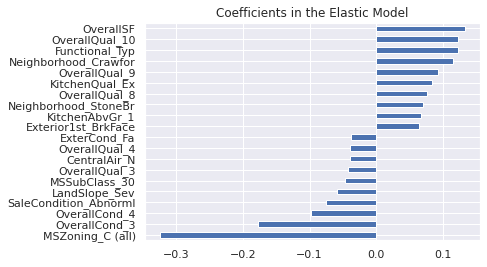

In [101]:
coefs_elastic = pd.Series(elasticv_reg.coef_, index = X_train.columns)
print("ElasticCV picked " + str(sum(coefs_elastic != 0)) + " features and eliminated the other " +  str(sum(coefs_elastic == 0)) + " features")
imp_coefs_elastic = pd.concat([coefs_elastic.sort_values().head(10), coefs_elastic.sort_values().tail(10)])
imp_coefs_elastic.plot(kind = "barh")
plt.title("Coefficients in the Elastic Model")
plt.show()

### XGBoost! <a name="subparagraph14"></a>
Convert the training and testing sets into DMatrixes: DMatrix is the recommended class in xgboost.

In [102]:
from xgboost import XGBRegressor
import xgboost as xgb 
d_train = xgb.DMatrix(data = X_train, 
                       label = y_train)

d_test =  xgb.DMatrix(data = X_test,
                       label = y_test)

In [103]:
#xgb_model = XGBRegressor()

In [104]:
#search_params = {
    #'max_depth': [2, 3],
    #'learning_rate': [0.01, 0.1, 1],
    #'n_estimators': [500, 800]}

In [105]:
#from sklearn.model_selection import GridSearchCV

#GS = GridSearchCV(estimator = xgb_model,
                 #param_grid = search_params,
                 #scoring = ['r2', 'neg_root_mean_squared_error'],
                 #refit = 'r2',
                 #cv = 5, 
                 #verbose = 1)

In [106]:
#GS.fit(X_train, y_train)
#print(GS.best_params_)
#print(GS.best_estimator_)
#print(GS.best_score_)

In [107]:
#y_test_xgboost=GS.best_estimator_.predict(X_test)
#y_train_xgboost = GS.best_estimator_.predict(X_train)
#print("XGB RMSE on Training set :", rmse_cv_train(GS.best_estimator_).mean())
#print("XGB RMSE on Test set :", rmse_cv_test(GS.best_estimator_).mean())
#print('R square Accuracy: ',r2_score(y_test,y_test_xgboost))
#print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_xgboost))
#print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_xgboost))

### Let's build a final model! <a name="subparagraph15"></a>
To save time let's create an XGB regressor with optimised hyperparameters

In [108]:
regressor = XGBRegressor(learning_rate = 0.1,
                         max_depth = 2,
                         n_estimators=800)
regressor.fit(X_train, y_train)
y_test_model=regressor.predict(X_test)
y_train_model = regressor.predict(X_train)

In [109]:
print("Model RMSE on Training set :", rmse_cv_train(regressor).mean())
print("Model RMSE on Test set :", rmse_cv_test(regressor).mean())
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_model))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_model))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_model))

Model RMSE on Training set : 0.12205155566722696
Model RMSE on Test set : 0.13571849268723074
----------ElasticNetCV----------
R square Accuracy:  0.9166885181106473
Mean Absolute Error Accuracy:  0.07951199484688848
Mean Squared Error Accuracy:  0.013126193595402496


Text(0, 0.5, 'Real values')

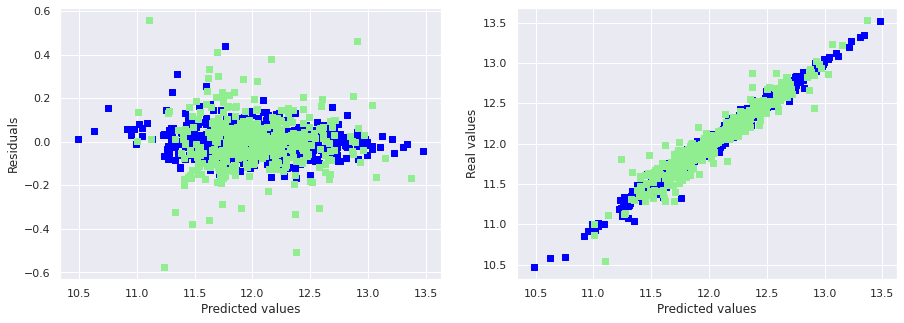

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_model, y_train_model - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_model, y_test_model - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_model, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_model, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

* ## Let's Predict SalePrice! <a name="paragraph4"></a>

In [111]:
test.head()

Id MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0  1461         20       RH    11622   Pave      Reg         Lvl    AllPub   
1  1462         20       RL    14267   Pave      IR1         Lvl    AllPub   
2  1463         60       RL    13830   Pave      IR1         Lvl    AllPub   
3  1464         60       RL     9978   Pave      IR1         Lvl    AllPub   
4  1465        120       RL     5005   Pave      IR1         HLS    AllPub   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story   
1    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story   
2    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story   
3    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story   
4    Inside       Gtl      StoneBr       Norm       Norm   TwnhsE     1Story   

  OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
0           5           6     Gable  CompShg     VinylSd     VinylSd   
1           6           6       Hip  CompShg     Wd Sdng     Wd Sdng   
2           5           5     Gable  CompShg     VinylSd     VinylSd   
3           6           6     Gable  CompShg     VinylSd     VinylSd   
4           8           5     Gable  CompShg     HdBoard     HdBoard   

  MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0       None         0.0        TA        TA     CBlock       TA       TA   
1    BrkFace       108.0        TA        TA     CBlock       TA       TA   
2       None         0.0        TA        TA      PConc       Gd       TA   
3    BrkFace        20.0        TA        TA      PConc       TA       TA   
4       None         0.0        Gd        TA      PConc       Gd       TA   

  BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
0           No          Rec       468.0          LwQ       144.0      270.0   
1           No          ALQ       923.0          Unf         0.0      406.0   
2           No          GLQ       791.0          Unf         0.0      137.0   
3           No          GLQ       602.0          Unf         0.0      324.0   
4           No          ALQ       263.0          Unf         0.0     1017.0   

  Heating HeatingQC CentralAir Electrical BedroomAbvGr KitchenAbvGr  \
0    GasA        TA          Y      SBrkr            2            1   
1    GasA        TA          Y      SBrkr            3            1   
2    GasA        Gd          Y      SBrkr            3            1   
3    GasA        Ex          Y      SBrkr            3            1   
4    GasA        Ex          Y      SBrkr            2            1   

  KitchenQual TotRmsAbvGrd Functional Fireplaces GarageType GarageFinish  \
0          TA            5        Typ          0     Attchd          Unf   
1          Gd            6        Typ          0     Attchd          Unf   
2          TA            6        Typ          1     Attchd          Fin   
3          Gd            7        Typ          1     Attchd          Fin   
4          Gd            5        Typ          0     Attchd          RFn   

  GarageCars  GarageArea GarageQual GarageCond PavedDrive MoSold YrSold  \
0        1.0       730.0         TA         TA          Y      6   2010   
1        1.0       312.0         TA         TA          Y      6   2010   
2        2.0       482.0         TA         TA          Y      3   2010   
3        2.0       470.0         TA         TA          Y      6   2010   
4        2.0       506.0         TA         TA          Y      1   2010   

  SaleType SaleCondition  TotalYears  OverallSF  TopFlrSF TotalBath  \
0       WD        Normal      2038.0     1778.0       896       1.0   
1       WD        Normal      2029.0     2658.0      1329       1.5   
2       WD        Normal      2147.0     2557.0      1629       2.5   
3       WD        Normal      2149.0     2530.0      1604       2

In [112]:
test.shape

(1459, 62)

In [113]:
numerical_features_test = test.select_dtypes(exclude = ["object"]).columns
numerical_features_test = [x for i,x in enumerate(numerical_features_test) if(x!='SalePrice') and (x!='LowQualFinPresent') and (x!='PoolPresent')and (x!='Id')]
print(numerical_features_test)

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalYears', 'OverallSF', 'TopFlrSF', 'TotalDeckPorch']


In [114]:
skewed_features = test[numerical_features_test].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['BsmtFinSF2', 'LotArea', 'MasVnrArea', 'TotalDeckPorch', 'OverallSF',
       'BsmtFinSF1', 'TopFlrSF', 'BsmtUnfSF'],
      dtype='object')

In [115]:
for i in skew_index:
    test[i] = boxcox1p(test[i], boxcox_normmax(test[i] + 1))

In [116]:
categorical_features

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'TotalBath'],
      dtype='object')

In [117]:
# The following code is for your test dataframe after training and testing on df dataframe
# Apply ohe on new dataframe
cat_ohe_test = ohe.transform(test[categorical_features])
#Create a Pandas DataFrame of the hot encoded column
ohe_df_test = pd.DataFrame(cat_ohe_test, columns = ohe.get_feature_names(input_features = categorical_features))

test = test.drop(categorical_features, axis=1)
#concat with original data and drop original columns
test = pd.concat([test, ohe_df_test], axis=1)

In [118]:
print(df.shape)
print(test.shape)

(1457, 348)
(1459, 349)


In [119]:
test.head()

Id    LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  GarageArea  \
0  1461  50.728192    0.000000   86.954089    7.403205  42.300174       730.0   
1  1462  54.118575   14.470534  137.046767    0.000000  53.960672       312.0   
2  1463  53.590846    0.000000  123.611305    0.000000  28.085210       482.0   
3  1464  48.336767    6.113887  102.958310    0.000000  47.173193       470.0   
4  1465  38.773077    0.000000   58.973113    0.000000  92.846754       506.0   

   TotalYears  OverallSF  TopFlrSF  TotalDeckPorch  PoolPresent  \
0      2038.0  23.647955  6.076302       42.678177            0   
1      2029.0  26.729865  6.387448       57.745794            0   
2      2147.0  26.418417  6.546516       41.268505            0   
3      2149.0  26.333631  6.534467       55.030650            0   
4      2131.0  26.427797  6.357973       39.195803            0   

   LowQualFinPresent  MSSubClass_120  MSSubClass_160  MSSubClass_180  \
0                  0             0.0             0.0             0.0   
1                  0             0.0             0.0             0.0   
2                  0             0.0             0.0             0.0   
3                  0             0.0             0.0             0.0   
4                  0             1.0             0.0             0.0   

   MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  \
0             0.0            1.0            0.0            0.0            0.0   
1             0.0            1.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0            0.0   

   MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            1.0            0.0            0.0            0.0   
3            0.0            1.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  \
0            0.0            0.0               0.0          0.0          1.0   
1            0.0            0.0               0.0          0.0          0.0   
2            0.0            0.0               0.0          0.0          0.0   
3            0.0            0.0               0.0          0.0          0.0   
4            0.0            0.0               0.0          0.0          0.0   

   MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  LotShape_IR1  \
0          0.0          0.0          0.0          1.0           0.0   
1          1.0          0.0          0.0          1.0           1.0   
2          1.0          0.0          0.0          1.0           1.0   
3          1.0          0.0          0.0          1.0           1.0   
4          1.0          0.0          0.0          1.0           1.0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0           0.0           0.0           1.0              0.0              0.0   
1           0.0           0.0           0.0              0.0              0.0   
2           0.0           0.0           0.0              0.0              0.0   
3           0.0           0.0           0.0              0.0              0.0   
4           0.0           0.0           0.0              0.0              1.0   

   LandContour_Low  LandContour_Lvl  Utilities_AllPub  Utilities_NoSeWa  \
0              0.0              1.0               1.0               0.0   
1              0.0              1.0               1.0               0.0   
2              0.0              1.0               1.0               0.0   
3              0.0       

In [120]:
test[numerical_features_test]  = stdSc_x.fit_transform(test[numerical_features_test])

In [121]:
test.head()

Id   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  GarageArea  \
0  1461  0.534497   -0.723133    0.280017    2.007432  -0.512036    1.185511   
1  1462  1.010596    0.616466    1.098348   -0.364751  -0.148677   -0.738518   
2  1463  0.936489   -0.723133    0.878861   -0.364751  -0.954998    0.043982   
3  1464  0.198678   -0.157144    0.541467   -0.364751  -0.360185   -0.011253   
4  1465 -1.144316   -0.723133   -0.177089   -0.364751   1.063076    0.154452   

   TotalYears  OverallSF  TopFlrSF  TotalDeckPorch  PoolPresent  \
0   -0.614325  -0.993664 -1.439363        0.622001            0   
1   -0.736324   0.272103 -0.181847        1.392659            0   
2    0.863219   0.144188  0.461034        0.549901            0   
3    0.890330   0.109366  0.412337        1.253788            0   
4    0.646332   0.148041 -0.300974        0.443890            0   

   LowQualFinPresent  MSSubClass_120  MSSubClass_160  MSSubClass_180  \
0                  0             0.0             0.0             0.0   
1                  0             0.0             0.0             0.0   
2                  0             0.0             0.0             0.0   
3                  0             0.0             0.0             0.0   
4                  0             1.0             0.0             0.0   

   MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  \
0             0.0            1.0            0.0            0.0            0.0   
1             0.0            1.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0            0.0   

   MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            1.0            0.0            0.0            0.0   
3            0.0            1.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  \
0            0.0            0.0               0.0          0.0          1.0   
1            0.0            0.0               0.0          0.0          0.0   
2            0.0            0.0               0.0          0.0          0.0   
3            0.0            0.0               0.0          0.0          0.0   
4            0.0            0.0               0.0          0.0          0.0   

   MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  LotShape_IR1  \
0          0.0          0.0          0.0          1.0           0.0   
1          1.0          0.0          0.0          1.0           1.0   
2          1.0          0.0          0.0          1.0           1.0   
3          1.0          0.0          0.0          1.0           1.0   
4          1.0          0.0          0.0          1.0           1.0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0           0.0           0.0           1.0              0.0              0.0   
1           0.0           0.0           0.0              0.0              0.0   
2           0.0           0.0           0.0              0.0              0.0   
3           0.0           0.0           0.0              0.0              0.0   
4           0.0           0.0           0.0              0.0              1.0   

   LandContour_Low  LandContour_Lvl  Utilities_AllPub  Utilities_NoSeWa  \
0              0.0              1.0               1.0               0.0   
1              0.0              1.0               1.0               0.0   
2              0.0              1.0               1.0               0.0   
3              0.0             

In [122]:
test_id = test['Id']
test = test.drop(['Id'], axis=1)

In [123]:
test_pred = pd.DataFrame(test_id, columns=['Id']) 
submission = pd.DataFrame(test_id, columns=['Id']) 

In [124]:
regressor_out = regressor.predict(test)
test_pred=pd.DataFrame(regressor_out,columns=['SalePrice_model_log'])
test_pred['SalePrice_regressor'] = np.exp(test_pred.SalePrice_model_log)
submission['SalePrice'] = np.exp(test_pred.SalePrice_model_log)
test_pred.head()

SalePrice_model_log  SalePrice_regressor
0            11.774219        129860.820312
1            11.999989        162752.921875
2            12.232218        205297.968750
3            12.255903        210218.593750
4            12.168530        192630.562500

In [125]:
test_pred['SalePrice_lasso_log']=lassocv_reg.predict(test)
test_pred['SalePrice_lasso'] =np.exp(test_pred.SalePrice_lasso_log)
test_pred.head()

SalePrice_model_log  SalePrice_regressor  SalePrice_lasso_log  \
0            11.774219        129860.820312            11.693975   
1            11.999989        162752.921875            12.044269   
2            12.232218        205297.968750            12.177925   
3            12.255903        210218.593750            12.214303   
4            12.168530        192630.562500            12.126680   

   SalePrice_lasso  
0    119847.429730  
1    170121.627769  
2    194448.983780  
3    201652.816435  
4    184735.372416

In [126]:
sample_submission['Lasso_pred']=test_pred['SalePrice_lasso']
sample_submission['XgBoost_pred']=test_pred['SalePrice_regressor']
sample_submission.head(10)

Id      SalePrice     Lasso_pred   XgBoost_pred
0  1461  169277.052498  119847.429730  129860.820312
1  1462  187758.393989  170121.627769  162752.921875
2  1463  183583.683570  194448.983780  205297.968750
3  1464  179317.477511  201652.816435  210218.593750
4  1465  150730.079977  184735.372416  192630.562500
5  1466  177150.989247  173430.775710  170814.781250
6  1467  172070.659229  182541.101035  178654.531250
7  1468  175110.956520  162842.035002  171431.171875
8  1469  162011.698832  194832.528366  184660.468750
9  1470  160726.247831  123007.798834  123504.210938

<AxesSubplot:xlabel='XgBoost_pred', ylabel='SalePrice'>

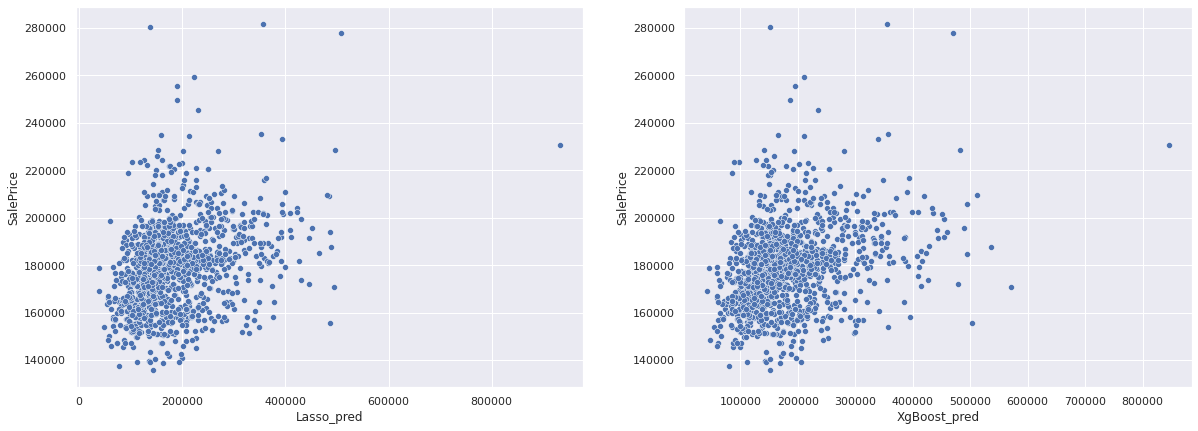

In [127]:
fig, ax = plt.subplots(1, 2, figsize =(20, 7))
sns.scatterplot(x= sample_submission['Lasso_pred'], y=sample_submission['SalePrice'], ax=ax[0])
sns.scatterplot(x= sample_submission['XgBoost_pred'], y=sample_submission['SalePrice'], ax=ax[1])

**Not too sure if it's better than last time! Tried to scale the target variable in an earlier version but didn't see much difference. A bit unsure if this is the correct approach**

In [128]:
submission.head(10)

Id      SalePrice
0  1461  129860.820312
1  1462  162752.921875
2  1463  205297.968750
3  1464  210218.593750
4  1465  192630.562500
5  1466  170814.781250
6  1467  178654.531250
7  1468  171431.171875
8  1469  184660.468750
9  1470  123504.210938

In [129]:
submission.to_csv('submission.csv', index=False)